Output variable -> y
y -> Whether the client has subscribed a term deposit or not 
Binomial ("yes" or "no")

Attribute information For bank dataset

   Input variables:
   
   # bank client data:
   
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   
   # related with the last contact of the current campaign:
   
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
  
   # other attributes:
   
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

8. Missing Attribute Values: None

The data is related with marketing campaigns of a banking institution.
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('bank-full.csv',';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(45211, 17)
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [4]:
#pd.set_option('max_cols',17)
df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [5]:
df.head(50)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [6]:
df.tail(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,success,yes
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,unknown,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,unknown,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


no     39922
yes     5289
Name: y, dtype: int64


<AxesSubplot:xlabel='y', ylabel='count'>

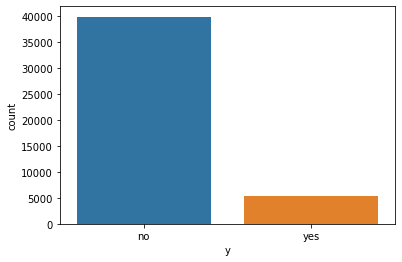

In [7]:
print(df.y.value_counts())
sns.countplot(df.y)

* Data is imbalanced as for yes the data is very less
* will use weight class in models to balance data
* yes/no ratio is 1/8

In [8]:
le = LabelEncoder()
for column_name in df.columns:
    if df[column_name].dtypes == object:
        df[column_name] = le.fit_transform(df[column_name])
    else:
        pass

In [9]:
print(df.dtypes)
df.describe(include='all')

age          int64
job          int32
marital      int32
education    int32
default      int32
balance      int64
housing      int32
loan         int32
contact      int32
day          int64
month        int32
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int32
y            int32
dtype: object


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,1362.272058,0.555838,0.160226,0.640242,15.806419,5.523014,258.163080,2.763841,40.197828,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,3044.765829,0.496878,0.366820,0.897951,8.322476,3.006911,257.527812,3.098021,100.128746,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,2.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


0    39922
1     5289
Name: y, dtype: int64


<AxesSubplot:xlabel='y', ylabel='count'>

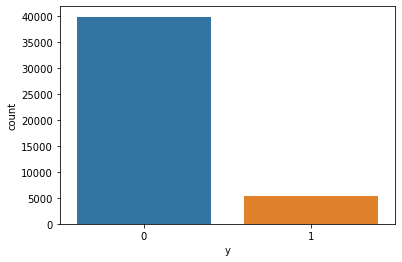

In [10]:
print(df.y.value_counts())
sns.countplot(df.y)

* yes - 1 -- 5289  observations 
* No  - 0 -- 39922 observations
* imbalanced dataset

In [11]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


In [12]:
x = df.iloc[:,:-1]
y = df[['y']]
#x

In [13]:
scaler        = StandardScaler()
x_transformed = scaler.fit_transform(x)
#print(x_transformed)

# only for checking whether the data is transformed or not
# checking display for mean=0 and SD =1
colsname = x.columns
x_transformed_display = pd.DataFrame(x_transformed,columns=colsname)
print(x_transformed_display.std())
print(x_transformed_display.mean())

age          1.000011
job          1.000011
marital      1.000011
education    1.000011
default      1.000011
balance      1.000011
housing      1.000011
loan         1.000011
contact      1.000011
day          1.000011
month        1.000011
duration     1.000011
campaign     1.000011
pdays        1.000011
previous     1.000011
poutcome     1.000011
dtype: float64
age          5.222844e-16
job          1.560056e-14
marital      4.638734e-15
education   -2.928306e-14
default      4.520540e-15
balance      3.070663e-15
housing      1.382298e-14
loan        -1.275129e-14
contact      3.943212e-14
day         -9.219436e-15
month        5.036415e-14
duration     5.560938e-17
campaign     1.254699e-14
pdays       -1.395817e-13
previous     1.355210e-13
poutcome     4.671375e-14
dtype: float64


## Without scaling input

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 10, stratify=y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(36168, 16)
(9043, 16)
(36168, 1)
(9043, 1)


### Model building, training, testing - w/o scaling

In [15]:
# LR
lr_model = LogisticRegression(class_weight={0:1,1:8}, random_state=10)
lr_model.fit(x_train,y_train)
y_pred_train_lr  = lr_model.predict(x_train)
y_pred_test_lr   = lr_model.predict(x_test)
#DT
dt_model = DecisionTreeClassifier(class_weight={0:1,1:8}, random_state=10)
dt_model.fit(x_train,y_train)
y_pred_train_dt  = dt_model.predict(x_train)
y_pred_test_dt   = dt_model.predict(x_test)
#RF
rf_model = RandomForestClassifier(class_weight={0:1,1:8}, random_state=10)
rf_model.fit(x_train,y_train)
y_pred_train_rf  = rf_model.predict(x_train)
y_pred_test_rf   = rf_model.predict(x_test)
#Ada Boosting
ab_model         = AdaBoostClassifier(random_state=10)
ab_model.fit(x_train,y_train)
y_pred_train_ab  = ab_model.predict(x_train)
y_pred_test_ab   = ab_model.predict(x_test)
#Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=10)
gb_model.fit(x_train,y_train)
y_pred_train_gb  = gb_model.predict(x_train)
y_pred_test_gb   = gb_model.predict(x_test)
#XGB
xgb_model = XGBClassifier(random_state=10)
xgb_model.fit(x_train,y_train)
y_pred_train_xgb  = xgb_model.predict(x_train)
y_pred_test_xgb   = xgb_model.predict(x_test)
#LGB
lgb_model = LGBMClassifier(random_state=10)
lgb_model.fit(x_train,y_train)
y_pred_train_lgb  = lgb_model.predict(x_train)
y_pred_test_lgb   = lgb_model.predict(x_test)

[08:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluation Metrics - w/o scaling

In [47]:
# Not working
#train_accuracy = []
#model_extension = ['lr','dt','rf','ab','gb','xgb','lgb']
#len(model_extension)
#for i in range (0, len(model_extension)):
#    pred_train_ = 'y_pred_train_'
#    pred_train_ = pred_train_+ model_extension[i]
#    print(pred_train_)
#    train_accuracy.append(round(accuracy_score(y_train,pred_train_),4))

#print(train_accuracy)

In [29]:
train_accuracy = []
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_lr),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_dt),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_rf),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_ab),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_gb),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_xgb),4))
train_accuracy.append(round(accuracy_score(y_train,y_pred_train_lgb),4))
#print(train_accuracy)

test_accuracy = []
#print("Test Accuracy Score")
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_lr),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_dt),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_rf),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_ab),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_gb),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_xgb),4))
test_accuracy.append(round(accuracy_score(y_test,y_pred_test_lgb),4))
#print(test_accuracy)

f1scorelist = []
#print("F1 Score")
f1scorelist.append(round(f1_score(y_test,y_pred_test_lr),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_dt),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_rf),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_ab),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_gb),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_xgb),4))
f1scorelist.append(round(f1_score(y_test,y_pred_test_lgb),4))

print("Without scaling")

table                   = pd.DataFrame(['LR','DT','RF','AB','GB','XGB','LGB'],columns={'Models'})
table['Train Accuracy'] = train_accuracy
table['Test Accuracy']  = test_accuracy
table['F1 Score']       = f1scorelist
table

Without scaling


,Models,Train Accuracy,Test Accuracy,F1 Score
0,LR,0.7671,0.7607,0.4263
1,DT,1.0000,0.8726,0.4435
2,RF,1.0000,0.9017,0.4549
3,AB,0.8984,0.8988,0.4511
4,GB,0.9095,0.9055,0.5003
5,XGB,0.9523,0.9052,0.5434
6,LGB,0.9322,0.9082,0.5566


## With scaling input

In [21]:
x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_transformed, y, test_size=0.20, random_state= 10, stratify=y)
print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(36168, 16)
(9043, 16)
(36168, 1)
(9043, 1)


### Model building, training, testing - with scaling

In [22]:
# LR
lr_model = LogisticRegression(class_weight={0:1,1:8}, random_state=10)
lr_model.fit(x_train_scaled,y_train)
y_pred_train_lr_scaled  = lr_model.predict(x_train_scaled)
y_pred_test_lr_scaled   = lr_model.predict(x_test_scaled)
#DT
dt_model = DecisionTreeClassifier(class_weight={0:1,1:8}, random_state=10)
dt_model.fit(x_train_scaled,y_train)
y_pred_train_dt_scaled  = dt_model.predict(x_train_scaled)
y_pred_test_dt_scaled   = dt_model.predict(x_test_scaled)
#RF
rf_model = RandomForestClassifier(class_weight={0:1,1:8}, random_state=10)
rf_model.fit(x_train_scaled,y_train)
y_pred_train_rf_scaled  = rf_model.predict(x_train_scaled)
y_pred_test_rf_scaled   = rf_model.predict(x_test_scaled)
#Ada Boosting
ab_model         = AdaBoostClassifier(random_state=10)
ab_model.fit(x_train_scaled,y_train)
y_pred_train_ab_scaled  = ab_model.predict(x_train_scaled)
y_pred_test_ab_scaled   = ab_model.predict(x_test_scaled)
#Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=10)
gb_model.fit(x_train_scaled,y_train)
y_pred_train_gb_scaled  = gb_model.predict(x_train_scaled)
y_pred_test_gb_scaled   = gb_model.predict(x_test_scaled)
#XGB
xgb_model = XGBClassifier(random_state=10)
xgb_model.fit(x_train_scaled,y_train)
y_pred_train_xgb_scaled  = xgb_model.predict(x_train_scaled)
y_pred_test_xgb_scaled   = xgb_model.predict(x_test_scaled)
#LGB
lgb_model = LGBMClassifier(random_state=10)
lgb_model.fit(x_train_scaled,y_train)
y_pred_train_lgb_scaled  = lgb_model.predict(x_train_scaled)
y_pred_test_lgb_scaled   = lgb_model.predict(x_test_scaled)


[08:48:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluation metrics - with scaling

In [28]:
# training Accuracy
#print("Training Accuracy Score")
accuracy_score_train_scaled =[] 
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_lr_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_dt_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_rf_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_ab_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_gb_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_xgb_scaled),4))
accuracy_score_train_scaled.append(round(accuracy_score(y_train,y_pred_train_lgb_scaled),4))
#print(accuracy_score_train_scaled)

#print("Test Accuracy Score")gbdt
accuracy_score_test_scaled =[] 
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_lr_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_dt_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_rf_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_ab_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_gb_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_xgb_scaled),4))
accuracy_score_test_scaled.append(round(accuracy_score(y_test,y_pred_test_lgb_scaled),4))
#print(accuracy_score_test_scaled)

#print("F1 Score")
f1scorelist_test = []
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_lr_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_dt_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_rf_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_ab_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_gb_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_xgb_scaled),4))
f1scorelist_test.append(round(f1_score(y_test,y_pred_test_lgb_scaled),4))
#print(f1scorelist_test)

print("With scaled input")

table_scaled                   = pd.DataFrame(['LR','DT','RF','AB','GB','XGB','LGB'],columns={'Models'})
table_scaled['Train Accuracy'] = accuracy_score_train_scaled
table_scaled['Test Accuracy']  = accuracy_score_test_scaled
table_scaled['F1 Score']       = f1scorelist_test
table_scaled

,Models,Train Accuracy,Test Accuracy,F1 Score
0,LR,0.7997,0.7974,0.4834
1,DT,1.0000,0.8725,0.4427
2,RF,1.0000,0.9019,0.4562
3,AB,0.8984,0.8988,0.4511
4,GB,0.9095,0.9055,0.5003
5,XGB,0.9523,0.9053,0.5442
6,LGB,0.9322,0.9080,0.5532


* Loaded the dataset for Term Deposit
* converted the categorical data into binary format using bitencoder
* Also, observations for Yes were very less compared to data for No in target variable
    yes - 1 -- 5289 observations
    No - 0 -- 39922 observations
* So, this is a case of imbalanced dataset, used weight class param in the models
* Checked the accuracy and F1 score of various models
    with scaling
    without scaling
* Also, tried to optimize the best model (LGBM) using hyperparameters tweaking
* But, there was no significant improvement with hyperparameters tweaking

* without scaling

    Models	Train Accuracy	Test Accuracy	F1 Score
	LR	    0.7671	        0.7607	        0.4263
	DT	    1.0000	        0.8726	        0.4435
	RF	    1.0000	        0.9017	        0.4549
	AB	    0.8984	        0.8988	        0.4511
	GB	    0.9095	        0.9055	        0.5003
	XGB	    0.9523	        0.9052	        0.5434
	LGB	    0.9322	        0.9082	        0.5566

* with scaling input

    Models	 Train Accuracy	 Test Accuracy	F1 Score
	LR	     0.7997	         0.7974	        0.4834
	DT	     1.0000	         0.8725	        0.4427
	RF	     1.0000	         0.9019	        0.4562
	AB	     0.8984	         0.8988	        0.4511
	GB	     0.9095	         0.9055	        0.5003
	XGB	     0.9523	         0.9053	        0.5442
	LGB	     0.9322	         0.9080	        0.5532

## Conclusion

* Light Gradient Boosting model is performing the best in terms of Accuracy and F1 score without scaling input
* Accuracy  = 90.82%
* F1 score  = 55.66%

### Model Optimization - using parameters for  XGB & LGB -- To boost accuracy

In [44]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train_scaled,label=y_train)

#setting parameters for xgboost
parameters={'max_depth':10, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':.05,
            'ntree_limit':'num_round'
           }

xg_model= xgb.train(parameters,dtrain,50) #50 iterations. Increase iterations for small learning rates

dtest                  = xgb.DMatrix(x_test_scaled)
y_pred_test_xgb_scaled = xg_model.predict(dtest)
y_pred_test_xgb_scaled

#Converting probabilities into 1 or 0  
for i in range(0, x_test.shape[0]): 
    if y_pred_test_xgb_scaled[i]>=.5:       # setting threshold to .5 
       y_pred_test_xgb_scaled[i]=1 
    else: 
       y_pred_test_xgb_scaled[i]=0 
    
print("Accuracy Test XGB with Params = ",accuracy_score(y_test,y_pred_test_xgb_scaled))
print("f1 score Test XGB with Params =",f1_score(y_test,y_pred_test_xgb_scaled))

[11:35:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "ntree_limit" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy Test XGB with Params =  0.9046776512219397
f1 score Test XGB with Params = 0.5289617486338798


In [53]:
import lightgbm as lgb
dtrain = lgb.Dataset(x_train_scaled, label=y_train)

lgbm_params = {'learning_rate':0.05, 
               'boosting_type':'gbdt',    #Try dart for better accuracy #gbdt
               'objective':'binary',
               'metric':['auc', 'binary_logloss'],
               'num_leaves':100,
               'max_depth':10}

lgb_model_params = lgb.train(lgbm_params, dtrain,50) #50 iterations. Increase iterations for small learning rates

y_pred_test_scaled_params = lgb_model_params.predict(x_test_scaled)

#convert into binary values 0/1 for classification
for i in range(0, x_test.shape[0]):
    if y_pred_test_scaled_params[i]>=.5:       # setting threshold to .5
       y_pred_test_scaled_params[i]=1
    else:  
       y_pred_test_scaled_params[i]=0
print()
print("Accuracy Test XGB with Params = ",accuracy_score(y_test,y_pred_test_scaled_params))
print("f1 score Test XGB with Params =",f1_score(y_test,y_pred_test_scaled_params))

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327

Accuracy Test XGB with Params =  0.9050093995355524
f1 score Test XGB with Params = 0.5060379528464634


* Even with model Optimization i.e by tweaking hyperparameters for LGB & XGB accuracy and f1_score is not improving
* so, Light Gradient Boosting model without scaling input is performing the best with
* Accuracy = 90.82%
* F1 score = 55.66%